In [1]:
import imutils
import time
import cv2
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import math
import random
%matplotlib notebook

In [2]:
from vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd, create_mobilenetv1_ssd_predictor
from vision.ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite, create_mobilenetv1_ssd_lite_predictor
from vision.ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite, create_squeezenet_ssd_lite_predictor
from vision.ssd.mobilenet_v2_ssd_lite import create_mobilenetv2_ssd_lite, create_mobilenetv2_ssd_lite_predictor
from vision.utils.misc import Timer

In [3]:
img_1 = cv2.imread("image/1.jpg")
img_2 = cv2.imread("image/2.jpg")
img_3 = cv2.imread("image/3.jpg")
img_4 = cv2.imread("image/4.jpg")
img_5 = cv2.imread("image/5.jpg")
img_6 = cv2.imread("image/6.jpg")
img_7 = cv2.imread("image/7.jpg")
img_8 = cv2.imread("image/8.jpg")
img_9 = cv2.imread("image/9.jpg")

In [4]:
def plot_img(img1, img2, img3, img4 = None):
    fig = plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')

    fig.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

    fig.add_subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.show()

    plt.figure(num=None, figsize=(6, 6), dpi=100, facecolor='w', edgecolor='k')
    plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    plt.show()

    if img4 is not None:
        plt.figure(num=None, figsize=(6, 6), dpi=100, facecolor='w', edgecolor='k')
        plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
    plt.show()

In [5]:
label_path = "models/voc-model-labels.txt"
model_path = "models/mobilenet-v1-ssd-mp-0_675.pth"

# label_path = "models/voc-model-labels.txt"
# model_path = "models/mb2-ssd-lite-mp-0_686.pth"

In [6]:
class_names = [name.strip() for name in open(label_path).readlines()]
num_classes = len(class_names)

net = create_mobilenetv1_ssd(len(class_names), is_test=True)
predictor = create_mobilenetv1_ssd_predictor(net, candidate_size=200)

# net = create_mobilenetv2_ssd_lite(len(class_names), is_test=True)
# predictor = create_mobilenetv2_ssd_lite_predictor(net, candidate_size=200)

net.load(model_path)

In [7]:
def camera2global(M, p):
    if len(p) == 2:
        p.append(1.)
    return np.matmul(M, p).astype(int)
def global2camera(M, p):
    if len(p) == 2:
        p.append(1.)
    return np.matmul(np.linalg.inv(M), p).astype(int)

In [8]:
pts1 = np.float32([[1100.,  151.],
       [ 335.,  951.],
       [1669.,  954.],
       [1884.,  156.]])

pts2 = np.float32([[ 624.,   82.],
       [ 619.,  997.],
       [1518.,  969.],
       [1530.,   43.]])

In [9]:
color_map = [(0, 180, 270), (255, 180, 0), (100, 170, 100)
            , (50, 255, 0), (0, 255, 30), (100, 30, 250)
            , (20, 90, 250), (200, 0, 20), (200, 200, 30)
            , (200, 30, 30), (200, 200, 20), (100, 30, 250)]

In [10]:
# cap = cv2.VideoCapture('video/normal_night.mp4')
# ret, frame = cap.read()
# pts1 = []
# pts2 = []
# count = [0]
# def click_Mouse(event, x, y, flags, param):
#     global click_p
#     if event == cv2.EVENT_LBUTTONUP:
#         if count[0] < 4:
#             pts1.append([x, y])
#         else:
#             pts2.append([x, y])
#         count[0] += 1

# cv2.namedWindow("vector", 0)
# cv2.resizeWindow("vector", 750, 750);
# cv2.setMouseCallback("vector", click_Mouse)
# cv2.imshow("vector", frame)
# # ch = cv2.waitKey(1)
# # if ch & 0xFF == ord('q'):
# cv2.waitKey(0)
# cv2.destroyAllWindows() 
# pts1 = np.float32(pts1) 
# pts2 = np.float32(pts2)

In [11]:
video1 = 'video/wind_rain.mp4'
video2 = 'video/normal_night.mp4'
video3 = 'video/dark.mp4'
video4 = 'video/622.mp4'
cam = 0   # capture from camera

In [12]:
def f(mu, sigma2, x):
    coefficient = 1.0/math.sqrt(2.0 * math.pi * sigma2)
    exponential = exp(-0.5 * (x-mu) ** 2 / sigma2)
    return coefficient * exponential
def update(mean1, var1, mean2, var2):
    new_mean = (var2 * mean1 + var1*mean2) / (var2 + var1)
    new_var = 1/(1/var2 + 1/var1)
    return [new_mean, new_var]
def predict(mean1, var1, mean2, var2):
    new_mean = mean1 + mean2
    new_var = var1 + var2
    return [new_mean, new_var]

In [13]:
def plot_img(img1, path):
    fig = plt.figure(num=None, figsize=(10, 10), dpi=200, facecolor='w', edgecolor='k')

    fig.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

    fig.add_subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(path, cv2.COLOR_BGR2RGB))
    plt.show()

In [14]:
class Obj(object):
    def __init__(self, pose, idx=-1, idleness=0):
        self.idleness = idleness
        self.idx = idx
        self.category = ""
        self.pose = pose
        self.path = [pose]
        self.alert_cnt = 0
        
    def get_idx(self):
        return self.idx
    
    def get_category(self):
        return self.category
    
    def get_idleness(self):
        return self.idleness
    
    def get_pose(self):
        return self.pose
    
    def get_alert_cnt(self):
        return self.alert_cnt
    
    def set_idx(self, idx):
        self.idx = idx
    
    def set_pose(self, pose):
        self.pose = pose
        self.path.append(pose)
        
    def reset_idleness(self):
        self.idleness = 0
    
    def add_idleness(self, num):
        self.idleness = self.idleness + num
        
    def reset_alert_cnt(self):
        self.alert_cnt = 0
    
    def add_alert_cnt(self, num):
        self.alert_cnt = self.alert_cnt + num
    
    def add_path(self, pose):
        self.path.append(pose)
    
    def get_path(self, idx=None):
        if idx is None:
            return self.path
        else:
            return self.path[idx]

In [27]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [61]:
def limit_rad(rad):
    if rad > np.pi:
        return limit_rad(rad - 2.*np.pi)
    elif rad < -np.pi:
        return limit_rad(rad + 2.*np.pi)
    else:
        return rad
    
def check_direction(rad, shift):
    rad = limit_rad(rad + np.pi/2. - shift)
    if rad > np.pi/4. and rad < 3.*np.pi/4.:
        return 1
    elif rad < -np.pi/4. and rad > -3.*np.pi/4.: 
        return -1
    return 0

def click_Mouse(event, x, y, flags, param):
    global click_p
    if event == cv2.EVENT_LBUTTONDOWN:
        click_p = [[x, y]]
    elif event == cv2.EVENT_LBUTTONUP:
        click_p.append([x, y])
        fy = click_p[1][1] - click_p[0][1]
        fx = click_p[1][0] - click_p[0][0]
        rad = np.arctan2(fy, fx)
        shift = np.radians(90.)
        direct = check_direction(rad, shift)
        print(np.degrees(rad), rad)

cv2.namedWindow("vector", 0)
cv2.resizeWindow("vector", 750, 750);
cv2.setMouseCallback("vector", click_Mouse)
cv2.imshow("vector", frame)
cv2.waitKey(0)
cv2.destroyAllWindows()  

96.813847515295 1.689720400665629


In [64]:
warp = False
src = video2
cap = cv2.VideoCapture(src)
M = cv2.getPerspectiveTransform(pts1,pts2)
M_shift = np.eye(3)
M_shift[0,2] = 942.48 # x
M_shift[1,2] = 383 # y
M_ = np.matmul(M_shift, M)
ret, frame = cap.read()
if warp:
    frame = cv2.warpPerspective(frame, M_,(frame.shape[1]+942, frame.shape[0]+383))
img_shape = frame.shape

In [69]:
SHIFT = 1.5639937106400879
cap = cv2.VideoCapture(src)
cv2.namedWindow("frame",0);
cv2.resizeWindow("frame", 750, 750);
cv2.namedWindow("path",0);
cv2.resizeWindow("path", 750, 750);
path = np.zeros((img_shape[0], img_shape[1], 3), np.uint8)
obj_list = []
idx_count = -1
alert = False
DIS_THRESH = 300
MOVE_THRESH = 3
while(cap.isOpened()):
    alert = False
    ret, frame = cap.read()
    if frame is not None:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, labels, probs = predictor.predict(image, 10, 0.35)
        boxes = boxes.numpy().astype(int)
        detections = []
        for i in range(len(boxes)):
            box = boxes[i, :]
            label = f"{class_names[labels[i]]}: {probs[i]:.2f}"
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 4)
            if warp:
                center = camera2global(M_, [(box[0]+box[2])/2, (box[1]+box[3])/2])
            else:
                center = [int((box[0]+box[2])/2), int((box[1]+box[3])/2)]
            obj = Obj(center[:2], i, 0)
            detections.append(obj)
            
            cv2.putText(frame, label,
                        (box[0]+20, box[1]+40),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,  # font scale
                        (255, 0, 255),
                        2)  # line type
    
        # Tracking Algorithm
        choose_detection_list = []
        for obj in obj_list:
            closest_detection_idx = -1
            min_dis = 1000000
            for detection in detections:
                if detection.get_idx() in choose_detection_list:
                    continue
                dis = distance(obj.get_pose(), detection.get_pose())
                if dis < DIS_THRESH and dis < min_dis:
                    closest_detection_idx = detection.get_idx()
                    min_dis = dis
            # keep tracking certain object
            if closest_detection_idx != -1:
                choose_detection_list.append(closest_detection_idx)
                obj.set_pose(detections[closest_detection_idx].get_pose())
                obj.reset_idleness()
                p1 = obj.get_path(-2)
                p2 = obj.get_path(-1)
                fx = p2[0] - p1[0]
                fy = p2[1] - p1[1]
                ang = np.arctan2(fy, fx)
                v = np.sqrt(fx * fx + fy * fy)
                if check_direction(ang, SHIFT) and v > MOVE_THRESH:
                    obj.add_alert_cnt(1)
                else:
                    obj.add_alert_cnt(-1)
            else:
                obj.add_idleness(1)
                
        for detection in detections:
            if detection.get_idx() not in choose_detection_list:
                idx_count += 1
                detection.set_idx(idx_count)
                obj_list.append(detection)
                
        temp_obj_list = []
        for obj in obj_list:
            if obj.get_idleness() < 3:
                temp_obj_list.append(obj)
                if obj.get_alert_cnt() > 3:
                    print(obj.get_alert_cnt())
                    alert = True
                    cv2.circle(path, tuple(obj.get_pose()), 15, (255, 255, 255), -1)
                else:
                    cv2.circle(path, tuple(obj.get_pose()), 15, color_map[obj.get_idx()%9], -1)
                
        obj_list = temp_obj_list.copy()
        if warp:
            frame = cv2.warpPerspective(frame, M_,(frame.shape[1]+942, frame.shape[0]+383))
        if alert:
            cv2.rectangle(frame, (0, 0), (img_shape[1]-1, img_shape[0]-1), (0, 0, 255), 50)
        else:
            cv2.rectangle(frame, (0, 0), (img_shape[1]-1, img_shape[0]-1), (0, 255, 0), 50)
        cv2.imshow('frame',frame)
        cv2.imshow('path',path)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

4
5
6
7
6
7
6
5
6
5
4
5
6
5
4
4
4
4
5
6
7
8
9
10
11
12
13
14
15
14
15
14
13
12
11
10
9
10
9
8
9
8
8
8
4
4
4
4
4
4


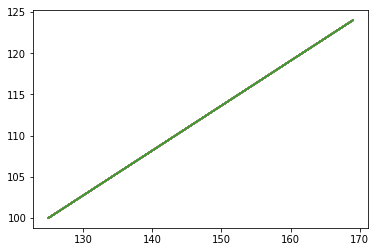

In [12]:
# Create capture object
cap = cv2.VideoCapture(5) # Flush the stream

#cap = cv2.VideoCapture(1) # Then start the webcam
# cap = cv2.VideoCapture('video/wind_rain.mp4')
cap = cv2.VideoCapture('video/normal_night.mp4')
# cap = cv2.VideoCapture('video/dark.mp4')
# cap = cv2.VideoCapture('video/622.mp4')
# cap = cv2.VideoCapture(0)   # capture from camera
# cap.set(3, 1920)
# cap.set(4, 1080)

cv2.namedWindow("frame",0);
cv2.resizeWindow("frame", 750, 750);
M = cv2.getPerspectiveTransform(pts1,pts2)
M_shift = np.eye(3)
M_shift[0,2] = 942.48 # x
M_shift[1,2] = 383 # y
M_ = np.matmul(M_shift, M)
while(cap.isOpened()):
    ret, frame = cap.read()
    if (frame is not None):
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        boxes, labels, probs = predictor.predict(image, 10, 0.25)
        for i in range(boxes.size(0)):
            box = boxes[i, :]
            label = f"{class_names[labels[i]]}: {probs[i]:.2f}"
            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (255, 255, 0), 4)

            cv2.putText(frame, label,
                        (box[0]+20, box[1]+40),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1,  # font scale
                        (255, 0, 255),
                        2)  # line type
            x = [125, 169]
            y = [100, 124]
            plt.plot(x, y)
        

#         frame = cv2.warpPerspective(frame, M_,(frame.shape[1]+942, frame.shape[0]+383))
#         frame = cv2.warpPerspective(frame, M,(frame.shape[1], frame.shape[0]))
#         frame = cv2.warpPerspective(frame, M_,(frame.shape[1], frame.shape[0]))
        cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [10]:
min_x = 1000
min_y = 1000
max_x = -1000
max_y = -1000
for i in range(frame.shape[0]): # y
    for j in range(frame.shape[1]): # x
        p = np.matmul(M, [j, i, 1])
        min_x = min(min_x, p[0])
        min_y = min(min_y, p[1])
        max_x = max(max_x, p[0])
        max_y = max(max_y, p[1])

In [37]:
p1 = np.array([frame.shape[1]-1, frame.shape[0]-1, 1])
p2 = np.array([frame.shape[1]-1, 0, 1])
p3 = np.array([0, frame.shape[0]-1, 1])
p4 = np.array([0, 0, 1])

In [44]:
c2g(M, p4)
g2c(M, c2g(M, p4))

array([0., 0., 1.])

In [30]:
a = np.matmul(M, [220, 219, 1])
a

array([-275.83737774,  302.7795715 ,    1.20523873])

In [31]:
np.matmul(np.linalg.inv(M), a)

array([220., 219.,   1.])

In [33]:
print(min_x, min_y, max_x, max_y)
print(frame.shape)

-942.4806114538623 -383.0608913082446 5570.814650645365 3053.9478925008257


AttributeError: 'NoneType' object has no attribute 'shape'